In [1]:
import os
import imp
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
import elephant
import pickle as pkl
from brian2 import *
import pdb
import sys
import pandas as pd

In [2]:
data_path = 'three_neuron_brian'
param_module = 'params_brian2_three_neurons.py'
os.makedirs(data_path, exist_ok=True)
jobname = param_module.replace('.py', '')
currdir = '/home/mikkel/Dropbox (UiO)/writing/causal-optoconnectics-paper/'
f, p, d = imp.find_module(jobname, [currdir])
p = imp.load_module(jobname, f, p, d).parameters

free_sim = True

### Set neurons


In [3]:
eqs = '''dV_m/dt = (g_L*(E_L-V_m)+Ie+Ii+I)/(C_m) : volt
         Ie = ge*(E_ex-V_m) : amp
         Ii = gi*(E_in-V_m) : amp
         dge/dt = -ge/(tau_syn_ex) : siemens
         dgi/dt = -gi/(tau_syn_in) : siemens
         I : amp'''
nodes = NeuronGroup(
    p['N_neurons'],
    model=eqs,
    threshold='V_m > V_th',
    reset='V_m = V_reset',
    refractory=p['t_ref'],
    namespace=p,
    method='euler',
)


nodes_stim = nodes[:2]

### Set connections from matrix

In [4]:
syn_ex = Synapses(
    nodes,
    nodes,
    model='w:siemens',
    on_pre='ge+=w',
    delay=p['syn_delay'])
 

syn_ex.connect(i=0, j=2)
syn_ex.w = p['J_ex']


WARNING    /home/mikkel/.virtualenvs/brian2/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/mikkel/.cython/brian_extensions/_cython_magic_5c7b6af2149031900b904634fec18ac5.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
/home/mikkel/.cython/brian_extensions/_cython_magic_5c7b6af2149031900b904634fec18ac5.cpp:27:20: fatal error: Python.h: No such file or directory
compilation terminated.
WARNING    Cannot use Cython, a test compilation failed: command 'x86_64-linux-gnu-gcc' failed with exit status 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.de

### Set background stimulation

In [5]:
poissInp = PoissonInput(
    nodes, 'ge',
    N=p['N_p'],
    rate=p['rate_p'],
    weight=p['J_ex'])

### Set spike monitors

In [6]:
# 1 for times without stim
spk_mon1 = SpikeMonitor(nodes)

# 2 for stimulation periods
spk_mon2 = SpikeMonitor(nodes)
spk_mon2_t = {}
spk_mon2_i = {}
spk_mon2.active = False

spk_trigger = {}

### Simulate

In [7]:
#nodes_stim_i = np.array(nodes_stim.i)

# find last index +1 of stim supgroup
idx_stop_pl_1 = nodes_stim.stop
# make sure that stim subgroups starts with 0
assert nodes_stim.start == 0


@network_operation
def stop_for_spikes():
#    if len(nodes_stim.spikes):
#    if len(np.in1d(nodes.spikes, nodes_stim_i)):
    # .spikes is not subgroup specific
    # therefore we have to manually check whether any of the occuring spikes
    # is from the subgroup.
    if len(nodes_stim.spikes) and np.searchsorted(nodes_stim.spikes, idx_stop_pl_1)>0:
        stop()

In [8]:
# run init time without stimulation
stop_for_spikes.active = False
run(p['init_simtime'])
sys.stdout.write('\r'+str(defaultclock.t/ms))

# now with stimulation
stop_for_spikes.active = True
run(p['runtime'] - defaultclock.t)

while defaultclock.t < p['runtime']:
    # stimulation only after init_simtime 
    stop_for_spikes.active = False
    # get timepoint of branching, shift by the delay of 0.2 ms
    t2 = defaultclock.t/ms - 0.2
    spk_trigger[float(spk_mon1.t[-1])] = spk_mon1.i[-1]
    # store network state before stimulation
    store()
    # We'll need an explicit seed here, otherwise we'll continue with different
    # random numbers after the restore
    use_seed = randint(iinfo(np.int32).max)
    seed(use_seed)
    # change spike monitors
    spk_mon1.active = False
    spk_mon2.active = True
    # stimulate
    nodes_stim.I = p['stim_amp_ex']
    run(p['stim_duration'])
    # turn stimuli off, but keep on simulation
    t_left = p['simtime_stim'] - p['stim_duration']
    nodes_stim.I = 0.*pA
    run(t_left)
    # store data of intermittent run
    spk_mon2_t[t2] = np.array(spk_mon2.t/ms)
    spk_mon2_i[t2] = np.array(spk_mon2.i).astype(int)
    # restore previous network state and continue with simulation
    stop_for_spikes.active = True
    restore()
    seed(use_seed)
    spk_mon1.active = True
    spk_mon2.active = False
    sys.stdout.write('\r'+str(defaultclock.t/ms))
    run(p['runtime'] - defaultclock.t)

991.1000000000001

In [9]:
defaultclock.t/ms

1000.0

### Store spikes

In [10]:
t1, i1 = np.array(spk_mon1.t), np.array(spk_mon1.i)
with open(str(data_path) + '/' + 'spks1.csv', 'w') as f:
        pd.DataFrame({'t': t1, 'id': i1.astype(int)}
        ).to_csv(f, header=False, index=False)

In [11]:
data = {
    'spk_ids': spk_mon2_i,
    'spk_ts': spk_mon2_t,
    'nodes_stim': np.array(nodes_stim.i)}
np.savez(data_path + 'stimulation_data.npz', data=data)

### Visualize spikes

(0.525, 0.55)

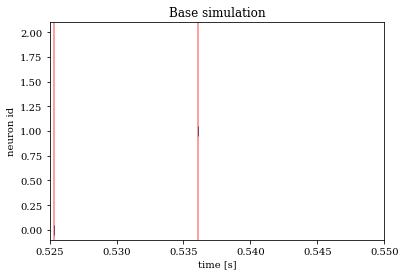

In [15]:
fig, ax = plt.subplots(1)
ax.plot(spk_mon1.t/second, spk_mon1.i, '|', markersize=10)
ax.set_title('Base simulation')
ax.set_xlabel('time [s]')
ax.set_ylabel('neuron id')

# visualize also branching points
br_points = np.array(sorted(spk_mon2_i.keys()))/1000
a=[ax.axvline(x, c='r', alpha=0.5) for x in br_points]

ax.set_xlim(0.525, 0.550)

In [13]:
spk_trigger

{0.5253: 0,
 0.5361: 1,
 0.5728: 0,
 0.5798: 1,
 0.6117: 0,
 0.6209: 1,
 0.6408: 0,
 0.6673: 1,
 0.7017: 1,
 0.7135: 0,
 0.7578: 1,
 0.8147000000000001: 1,
 0.8317: 0,
 0.8586: 1,
 0.9162: 1,
 0.92: 0,
 0.9884000000000001: 1,
 0.9909: 0}

In [14]:
br_points

array([0.5253, 0.5361, 0.5728, 0.5798, 0.6117, 0.6209, 0.6408, 0.6673,
       0.7017, 0.7135, 0.7578, 0.8147, 0.8317, 0.8586, 0.9162, 0.92  ,
       0.9884, 0.9909])

In [14]:
zidx = np.searchsorted(t1, br_points)

In [15]:
br_points

array([0.5355, 0.549 , 0.6023, 0.6111, 0.635 , 0.6482, 0.6718, 0.6948,
       0.719 , 0.7317, 0.7588, 0.8009, 0.8141, 0.8468, 0.8832, 0.9187,
       0.9262, 0.9521, 0.9881, 0.9951])

In [19]:
(t1[zidx-1] - br_points) * 1000

array([-3.88000000e+01, -1.35000000e+01, -1.00000000e-01, -8.80000000e+00,
       -2.39000000e+01, -1.32000000e+01, -2.19000000e+01, -2.30000000e+01,
       -1.76000000e+01, -1.27000000e+01, -2.55000000e+01, -3.13000000e+01,
       -8.30000000e+00, -1.11022302e-13, -2.36000000e+01, -1.27000000e+01,
       -7.50000000e+00, -2.59000000e+01, -7.00000000e-01, -7.00000000e+00])

In [16]:
assert len(t1[zidx-1]) == len(set(t1[zidx-1]))

In [25]:
Z_A = i1[zidx-1] == 0
Z_B = i1[zidx-1] == 1

In [ ]:
X_

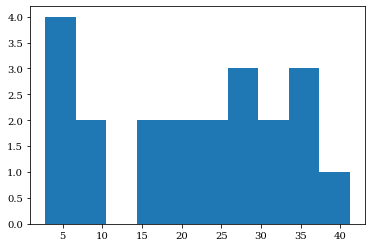

In [13]:
plt.hist(np.diff(br_points)*1000, bins=10);

In [14]:
np.min(np.diff(br_points)) * 1000

2.7999999999999137

In [13]:
spikes, neuron_id = spk_mon1.t / second, spk_mon1.i


In [17]:
from causal_optoconnectics.core import causal_connectivity, find_response_spikes

In [18]:
A, B, C = [spikes[neuron_id==s] for s in [0,1,2]]

In [19]:
find_response_spikes(A,C,br_points)

TypeError: find_response_spikes() missing 2 required positional arguments: 'dt' and 'dz'

KeyError: 17.0

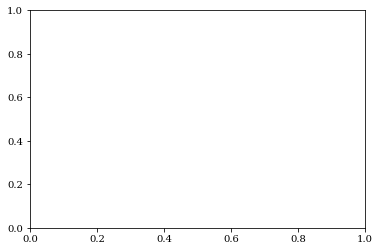

In [14]:
t_sel = 
fig, ax = plt.subplots(1)
ax.plot(spk_mon2_t[t_sel], spk_mon2_i[t_sel], '|')
ax.set_title('Branched out stimulation')
ax.set_xlabel('time [ms]')
ax.set_ylabel('neuron id')

### Test whether stimulations occur whenever a spike in stimulated group fires

In [20]:
br_points = np.array(list(spk_mon2_i.keys()))

In [21]:
i_stim = np.array(nodes_stim.i)
i = np.array(spk_mon1.i)
t = spk_mon1.t/ms
i_bool = np.in1d(i, i_stim)
t_bool = (t > p['init_simtime']/ms) & (t < p['runtime']/ms-0.3)

t_stim = np.unique(t[(i_bool) & (t_bool)])

assert np.allclose(t_stim, br_points)